# Soccer Data Analysis

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
    <ul>
        <li><a href="#general">General Properties</a></li>
        <li><a href="#clean">Data Cleaning</a></li>
    </ul>
<li><a href="#eda">Exploratory Data Analysis</a></li>
    <ul>
        <li><a href="#q1">Question One</a></li>
        <li><a href="#q2">Question Two</a></li>
    </ul>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

In this project I'll be analyzing data associated with soccer matches, I will specifically be looking at shots, fouls, possession, and player rating data to look for possible correlations and differences between winning and losing teams.
<ol>
    <li> How (if at all) are these match attributes correlated with winning or losing? </li>
    <li> How (if at all) are these match attributes correlated with one-another when winning or losing? </li>
</ol>

First, I will import the necessary packages that will be used for this project:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from xml.etree import ElementTree as ET
%matplotlib inline

<a id='wrangling'></a>
## Data Wrangling
<a id='general'></a>
### General Properties
In this section, I connect to the database, load the tables, and look at the summary info of each table. This is better understood by looking at the documentation from the source: https://www.kaggle.com/hugomathien/soccer

In [2]:
conn = sqlite3.connect('database.sqlite')
tables = pd.read_sql("""SELECT *
                        FROM sqlite_master
                        WHERE type='table';""", conn)
table_df = {}
for i in range(len(tables['name'])):
    table_df[tables.name[i].lower()] = pd.read_sql("""SELECT * FROM {};""".format(tables.name[i]), conn)

In [3]:
for key in table_df.keys():
    print('\t', key)
    print(table_df[key].info())

	 sqlite_sequence
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 2 columns):
name    7 non-null object
seq     7 non-null int64
dtypes: int64(1), object(1)
memory usage: 240.0+ bytes
None
	 player_attributes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183978 entries, 0 to 183977
Data columns (total 42 columns):
id                     183978 non-null int64
player_fifa_api_id     183978 non-null int64
player_api_id          183978 non-null int64
date                   183978 non-null object
overall_rating         183142 non-null float64
potential              183142 non-null float64
preferred_foot         183142 non-null object
attacking_work_rate    180748 non-null object
defensive_work_rate    183142 non-null object
crossing               183142 non-null float64
finishing              183142 non-null float64
heading_accuracy       183142 non-null float64
short_passing          183142 non-null float64
volleys                181265 non-null 

<a id='clean'></a>
### Data Cleaning
Of the available data, relatively little will be needed to answer our questions. However, much of it is spread among multiple tables and will need to be joined together. Also, large parts of the data I wish to access is concealed in XML and will need to be extracted.

I load in the necessary match data to a pandas DataFrame from the SQL database:

In [4]:
match_df = pd.read_sql("""SELECT id AS id, home_team_goal AS home_goals,
                               home_team_api_id AS home_id,
                               away_team_goal AS away_goals,
                               away_team_api_id AS away_id,
                               shoton AS shots_on,
                               shotoff AS shots_off,
                               foulcommit AS fouls_commit,
                               possession
                          FROM "Match";""", conn)

I then perform twenty-two joins, compressed in a for loop, to add the overall rating for every player in each match.

In [5]:
for value, char in zip(('home', 'away'), ('h', 'a')):  # Adds the Overall Rating for every player in the match.
    for i in range(11):
        df = pd.read_sql("""SELECT m.id AS id, p.overall_rating AS {}p{}_rating
                            FROM Match m
                            JOIN Player_Attributes p
                            ON p.player_api_id = m.{}_player_{} AND m.date >= p.date
                            GROUP BY m.date;""".format(char, i + 1, value, i + 1), conn)
        match_df = match_df.merge(df, how='outer')

Because I'm only interested in winners and losers, we'll get rid of any rows that were ties or are missing goal data for either team.

In [6]:
match_df = match_df.loc[match_df.home_goals != match_df.away_goals]
match_df.dropna(subset=['home_goals'], inplace=True)
match_df.dropna(subset=['away_goals'], inplace=True)

I add a column to describe whether or not the home team won, this will be used on multiple occassions. I then subdivide the data into different DataFrames so that the correct dropping, renaming and concatenating are possible.

In [10]:
match_df['home_win'] = 0
match_df.loc[(match_df.home_goals > match_df.away_goals), 'home_win'] = 1
home_winner_df = match_df[match_df.home_win == 1]
home_loser_df = match_df[match_df.home_win == 0]
away_winner_df = match_df[match_df.home_win == 0]
away_loser_df = match_df[match_df.home_win == 1]

In [8]:
def DropUnimportant(df, home):
    """Drops rows that are not needed for the DataFrame and renames columns to make them consistent across DataFrames."""
    columns = ['team_id', 'shots_on', 'shots_off', 'fouls_commit',
               'possession', 'p1_rating', 'p2_rating', 'p3_rating', 'p4_rating',
               'p5_rating', 'p6_rating', 'p7_rating', 'p8_rating', 'p9_rating',
               'p10_rating', 'p11_rating', 'home_win']
    if home:
        df.drop(['id', 'home_goals', 'away_goals', 'away_id', 'ap1_rating', 'ap2_rating', 'ap3_rating',
                 'ap4_rating', 'ap5_rating', 'ap6_rating', 'ap7_rating', 'ap8_rating',
                 'ap9_rating', 'ap10_rating', 'ap11_rating'], axis=1, inplace=True)
        df.columns = columns
    else:
        df.drop(['id', 'home_goals', 'away_goals', 'home_id', 'hp1_rating', 'hp2_rating', 'hp3_rating', 'hp4_rating',
                 'hp5_rating', 'hp6_rating', 'hp7_rating', 'hp8_rating', 'hp9_rating',
                 'hp10_rating', 'hp11_rating'], axis=1, inplace=True)
        df.columns = columns
    return df

I run each of these DataFrames through the previous function, manually specifying home or away team.

In [11]:
home_winner_df = DropUnimportant(home_winner_df, True)
home_loser_df = DropUnimportant(home_loser_df, True)
away_winner_df = DropUnimportant(away_winner_df, False)
away_loser_df = DropUnimportant(away_loser_df, False)

I then concatenate the DataFrames into a winning and a losing DataFrame. To more easily work with both DataFrames at once I point to them in a list.

In [12]:
winner_df = pd.concat([home_winner_df, away_winner_df])
loser_df = pd.concat([home_loser_df, away_loser_df])
both_df = [winner_df, loser_df]

I calculate the average overall rating of players and add it as a new column to the DataFrames. I then drop the now unnecessary individual player ratings. 

In [13]:
for df in both_df:
    df['avg_overall_rating'] = df.drop(['team_id', 'shots_on', 'shots_off', 'fouls_commit', 'possession', 'home_win'],
                                       axis=1).mean(axis=1)
    df.drop(['p1_rating', 'p2_rating', 'p3_rating', 'p4_rating',
             'p5_rating', 'p6_rating', 'p7_rating', 'p8_rating', 'p9_rating',
             'p10_rating', 'p11_rating'], axis=1, inplace=True)

#### XML Extraction Functions
Shots on, shots off, fouls, and possession percentage are all stored as XML data. The following functions allow for useful extraction of this data. 

In [14]:
def xml_count_extract(series, series_id, count=pd.Series()):
    """ Extracts count of occurrences of the team_id from the XML """
    for i in range(len(series)):
        try:
            root = ET.fromstring(series.iloc[i])
            counter = 0
            for value in root.findall('value'):
                if int(value.find('team').text) == series_id.iloc[i]:
                    counter += 1
                count.at[i] = counter
        except (TypeError, AttributeError) as error:
            count.at[i] = None
            continue
    return count

In [15]:
def xml_possession_extract(series, home, count=pd.Series()):
    """ Extracts average of possession values from the XML """
    numer = []
    denom = 0
    for i in range(len(series)):
        try:
            root = ET.fromstring(series.iloc[i])
            for value in root.findall('value'):
                if home.iloc[i]:
                    numer.append(int(value.find('homepos').text))
                    denom += 1
                else:
                    numer.append(int(value.find('awaypos').text))
                    denom += 1
            count.at[i] = sum(numer) / denom
        except (TypeError, AttributeError) as error:
            count.at[i] = None
            continue
    return count

I extract shots on, shots off, and fouls committed from both DataFrames, then force them to be numeric columns. 
I add the shots on and shots off columns together to create a shots column, and then drop the shots on and shots off columns.

In [16]:
for df in both_df:
    df.shots_on = xml_count_extract(df.shots_on, df.team_id)
    df.shots_off = xml_count_extract(df.shots_off, df.team_id)
    df.fouls_commit = xml_count_extract(df.fouls_commit, df.team_id)
    df.shots_on = pd.to_numeric(df.shots_on, errors='coerce')
    df.shots_off = pd.to_numeric(df.shots_off, errors='coerce')
    df.fouls_commit = pd.to_numeric(df.fouls_commit, errors='coerce')
    df['shots'] = df.shots_on + df.shots_off
    df.drop(['shots_on', 'shots_off'], axis=1, inplace=True)

I swap the home_win value to make it technically incorrect, but so that it works correctly with the function. It will be dropped anyways as it is used. 

In [17]:
loser_df.home_win = loser_df.home_win.apply(lambda x: 0 if x == 1 else 1)

I extract the average possession time of the given team and drop the now unnecessary team id and home win columns.
I'll also drop rows with no data and make the possession column numeric. 

In [18]:
for df in both_df:
    df.possession = xml_possession_extract(df.possession, df.home_win)
    df.drop(['team_id', 'home_win'], axis=1, inplace=True)
    df.dropna(how='all', inplace=True)
    df.possession = pd.to_numeric(df.possession, errors='coerce')

The data is now ready to be explored and looks like:

In [19]:
winner_df[winner_df.fouls_commit > 0].head()

,fouls_commit,possession,avg_overall_rating,shots
810,11.0,64.250000,NaN,25.0
814,14.0,53.450000,64.272727,12.0
820,12.0,53.880952,61.222222,20.0
821,9.0,53.739130,63.888889,7.0
824,13.0,53.396552,NaN,16.0


<a id='eda'></a>
## Exploratory Data Analysis
<a id='q1'></a>
### Question 1: How (if at all) are these match attributes correlated with winning or losing?
First we'll compare the means:

In [20]:
winner_df.mean()

fouls_commit          12.532361
possession            53.603156
avg_overall_rating    65.644272
shots                 11.785207
dtype: float64

In [21]:
loser_df.mean()

fouls_commit          12.768962
possession            48.190313
avg_overall_rating    63.965884
shots                 13.181119
dtype: float64

In [22]:
winner_df.mean() - loser_df.mean()

fouls_commit         -0.236601
possession            5.412842
avg_overall_rating    1.678388
shots                -1.395911
dtype: float64

Then we'll look at some Seaborn Distribution plots comparing each variable to better understand these mean's possible significance:

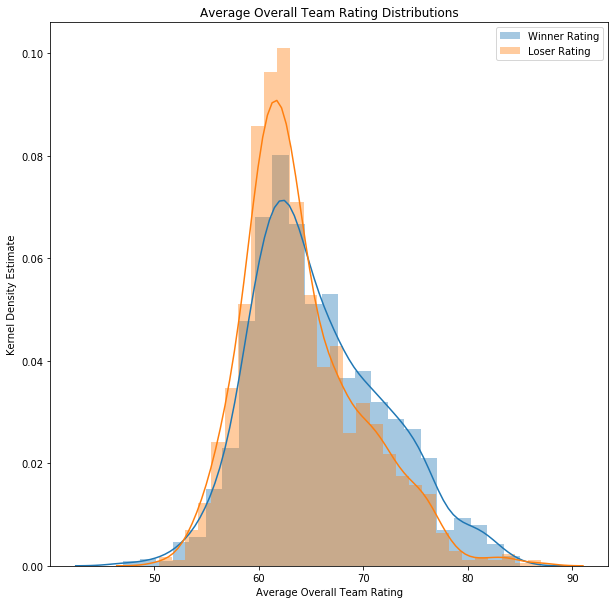

In [37]:
plt.figure(figsize=(10, 10))
sns.distplot(winner_df.avg_overall_rating.dropna())
sns.distplot(loser_df.avg_overall_rating.dropna())
plt.legend(labels=['Winner Rating', 'Loser Rating'])
plt.title("Average Overall Team Rating Distributions")
plt.xlabel("Average Overall Team Rating")
plt.ylabel("Kernel Density Estimate")
plt.show();

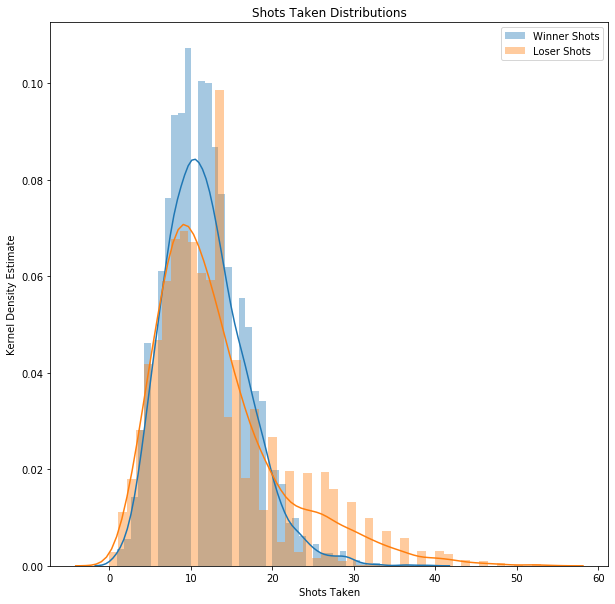

In [38]:
plt.figure(figsize=(10, 10))
sns.distplot(winner_df.shots.dropna())
sns.distplot(loser_df.shots.dropna())
plt.legend(labels=['Winner Shots', 'Loser Shots'])
plt.title("Shots Taken Distributions")
plt.xlabel("Shots Taken")
plt.ylabel("Kernel Density Estimate")
plt.show();

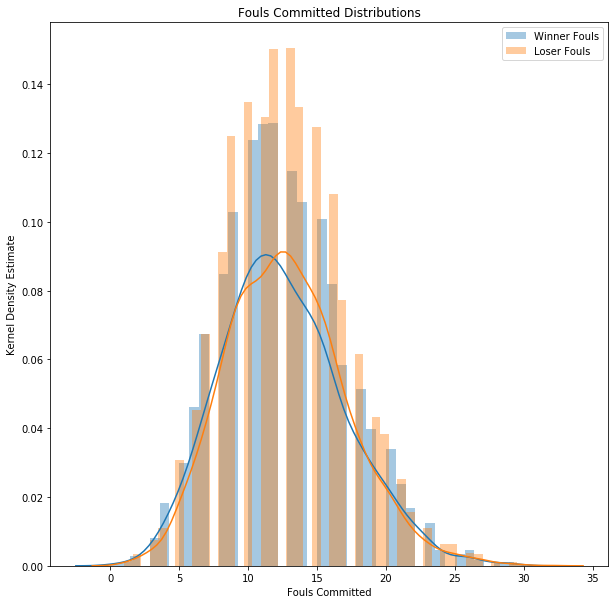

In [39]:
plt.figure(figsize=(10, 10))
sns.distplot(winner_df.fouls_commit.dropna())
sns.distplot(loser_df.fouls_commit.dropna())
plt.legend(labels=['Winner Fouls', 'Loser Fouls'])
plt.title("Fouls Committed Distributions")
plt.xlabel("Fouls Committed")
plt.ylabel("Kernel Density Estimate")
plt.show();

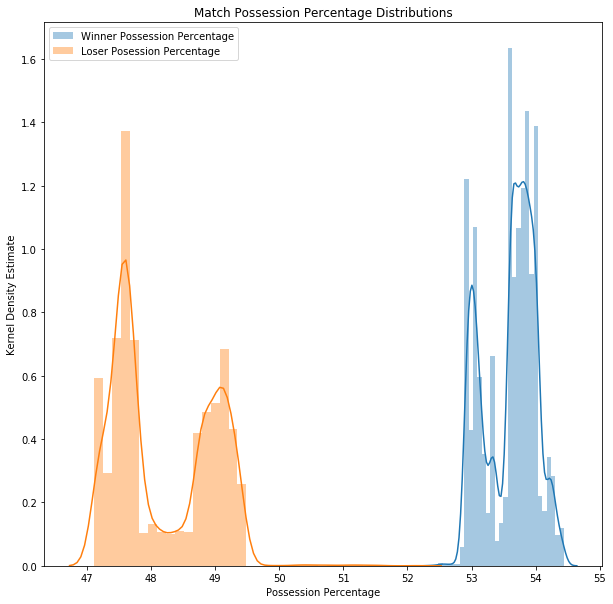

In [40]:
plt.figure(figsize=(10, 10))
sns.distplot(winner_df.possession.dropna())
sns.distplot(loser_df.possession.dropna())
plt.legend(labels=['Winner Possession Percentage', 'Loser Posession Percentage'])
plt.title("Match Possession Percentage Distributions")
plt.xlabel("Possession Percentage")
plt.ylabel("Kernel Density Estimate")
plt.show();

<a id='q2'></a>
### Question 2: How (if at all) are these match attributes correlated with one-another when winning or losing?

First I'll look at the Correlation Coefficients to get an idea of what may be correlated:

In [41]:
corrw = winner_df.corr()
corrw

,fouls_commit,possession,avg_overall_rating,shots
fouls_commit,1.000000,-0.216603,0.054976,-0.190069
possession,-0.216603,1.000000,0.205310,0.187762
avg_overall_rating,0.054976,0.205310,1.000000,-0.086276
shots,-0.190069,0.187762,-0.086276,1.000000


In [42]:
corrl = loser_df.corr()
corrl

,fouls_commit,possession,avg_overall_rating,shots
fouls_commit,1.000000,-0.060703,0.099431,0.099351
possession,-0.060703,1.000000,0.172224,0.036713
avg_overall_rating,0.099431,0.172224,1.000000,0.084114
shots,0.099351,0.036713,0.084114,1.000000


Then I'll make a heatmap of these magnitudes to further explore what may be correlated, darkest and lightest colors mean a greater possible correlation (Colors at 0 mean no correlation):

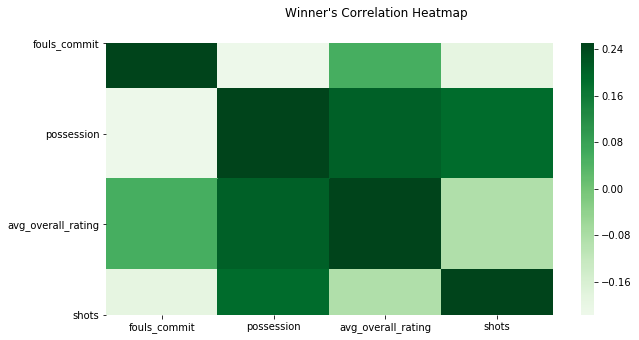

In [43]:
plt.figure(figsize=(10, 5)).suptitle('Winner\'s Correlation Heatmap')
sns.heatmap(corrw, xticklabels=corrw.columns.values, yticklabels=corrw.columns.values, center=0, vmax=.25, cmap='Greens');

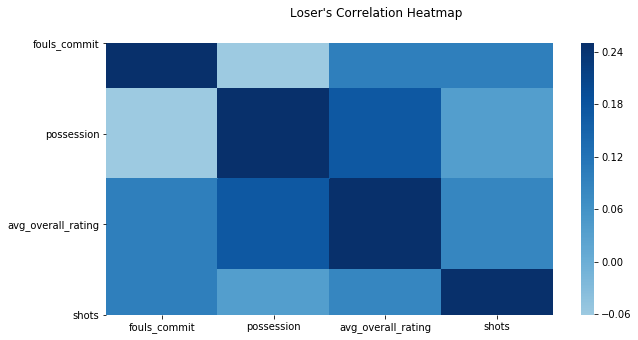

In [44]:
plt.figure(figsize=(10, 5)).suptitle('Loser\'s Correlation Heatmap')
sns.heatmap(corrl, xticklabels=corrl.columns.values, yticklabels=corrl.columns.values, center=0, vmax=.25, cmap='Blues');

Finally, I'll make some scatter plots with a line of best fit of each variables' correlation with Possession and Average Overall Rating because these two variables seem like they may provide the most interesting correlations:

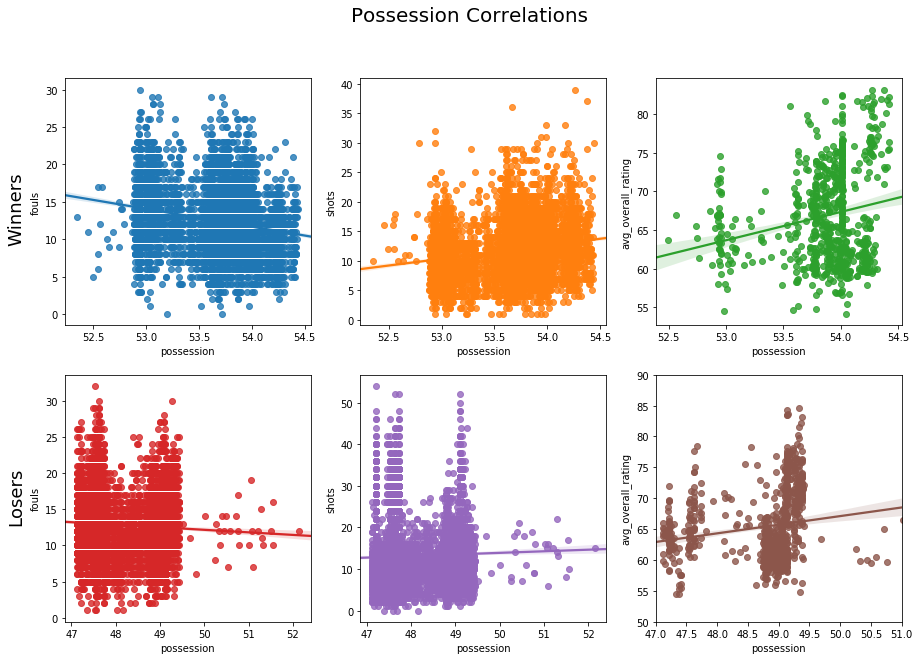

In [45]:
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(15,10))
fig.suptitle('Possession Correlations', fontsize=20)
sns.regplot(winner_df.possession, winner_df.fouls_commit, ax=axs[0][0])
axs[0][0].set(ylabel='fouls')
sns.regplot(winner_df.possession, winner_df.shots, ax=axs[0][1])
sns.regplot(winner_df.possession, winner_df.avg_overall_rating, ax=axs[0][2])
sns.regplot(loser_df.possession, loser_df.fouls_commit, ax=axs[1][0])
axs[1][0].set(ylabel='fouls')
sns.regplot(loser_df.possession, loser_df.shots, ax=axs[1][1])
sns.regplot(loser_df.possession, loser_df.avg_overall_rating, ax=axs[1][2])
axs[1][2].set_ybound(50,90)
axs[1][2].set_xbound(47,51)
fig.text(0.08,0.7, 'Winners', ha='center', va='center', rotation='vertical', fontsize=18)
fig.text(0.08,0.3, 'Losers', ha='center', va='center', rotation='vertical', fontsize=18);

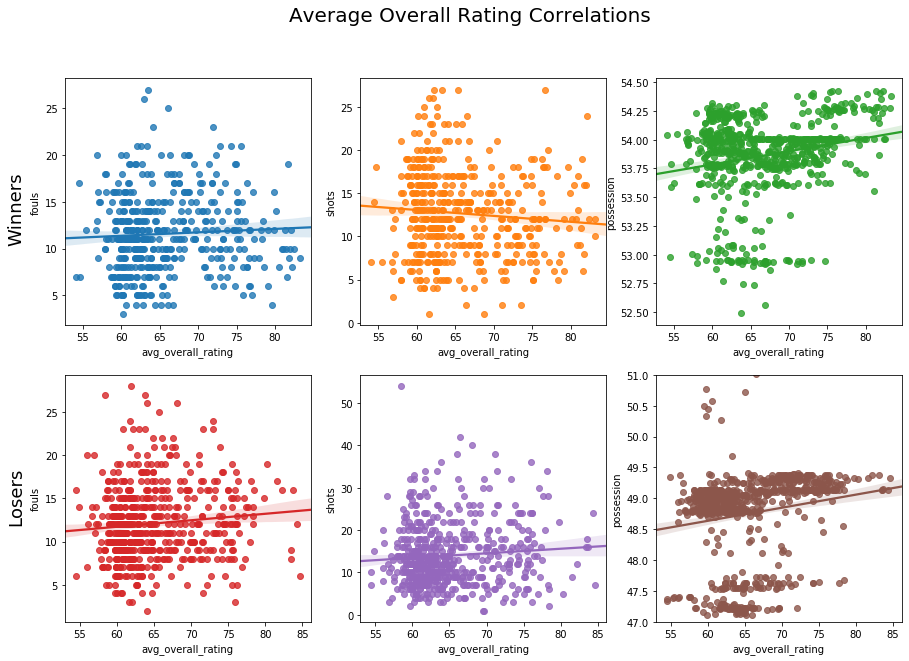

In [46]:
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(15,10))
fig.suptitle('Average Overall Rating Correlations', fontsize=20)
sns.regplot(winner_df.avg_overall_rating, winner_df.fouls_commit, ax=axs[0][0])
axs[0][0].set(ylabel='fouls')
sns.regplot(winner_df.avg_overall_rating, winner_df.shots, ax=axs[0][1])
sns.regplot(winner_df.avg_overall_rating, winner_df.possession, ax=axs[0][2])
sns.regplot(loser_df.avg_overall_rating, loser_df.fouls_commit, ax=axs[1][0])
axs[1][0].set(ylabel='fouls')
sns.regplot(loser_df.avg_overall_rating, loser_df.shots, ax=axs[1][1])
sns.regplot(loser_df.avg_overall_rating, loser_df.possession, ax=axs[1][2])
axs[1][2].set_ybound(47,51)
fig.text(0.08,0.7, 'Winners', ha='center', va='center', rotation='vertical', fontsize=18)
fig.text(0.08,0.3, 'Losers', ha='center', va='center', rotation='vertical', fontsize=18);

<a id='conclusions'></a>
## Conclusions
It appears that winning teams' match stats show that they on average:
<ul>
    <li>Commit fewer Fouls than losing teams.</li>
    <li>Have a higher Possession Percentage than losing teams.</li>
    <li>Have a higher Average Overall Player Rating than losing teams.</li>
    <li>Take fewer Shots than losing teams.</li>
</ul>
Further Statistical tests would be necessary to know the statistical significance of these general observations. 

It also appears that:
<ul>
    <li>Possession is negatively correlated with fouls committed.</li>
    <li>Possession is positively correlated with shots taken and average overall rating.</li>
    <br>
    <li>Average overall rating is not very correlated with fouls committed.</li>
    <li>Average overall rating is correlated with fewer shots taken for winning teams, and more shots taken for losing teams.</li>
    <li>Average overall rating is positively correlated with possession.</li>
</ul>
Again, further statistical tests would be necessary to know the statistical significance of these observations. 